https://seongkyun.github.io/study/2019/11/21/cnn_problem/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


https://www.kaggle.com/code/milankalkenings/pytorch-3-batch-normalization

In [4]:
def get_mean_std_dataset(dataset):
    meanRGB = [np.mean(image, axis=(1, 2)) for image,_ in dataset]
    stdRGB = [np.std(image, axis=(1, 2)) for image,_ in dataset]
    
    meanR = np.round( (np.mean([m[0] for m in meanRGB]) / 255), 3)
    meanG = np.round( (np.mean([m[1] for m in meanRGB]) / 255), 3)
    meanB = np.round( (np.mean([m[2] for m in meanRGB]) / 255), 3)
    
    stdR = np.round( (np.mean([s[0] for s in stdRGB]) / 255), 3)
    stdG = np.round( (np.mean([s[1] for s in stdRGB]) / 255), 3)
    stdB = np.round( (np.mean([s[2] for s in stdRGB]) / 255), 3)
    
    print("mean RGB:", meanR, meanG, meanB)
    print("std RGB:", stdR, stdG, stdB)
    
    return {"mean": [meanR, meanG, meanB], "std": [stdR, stdG, stdB]}

In [5]:
train_set = torchvision.datasets.ImageFolder(root="../data/refined_fer2013/train")
test_set = torchvision.datasets.ImageFolder(root="../data/refined_fer2013/test")

In [6]:
train_mean_std = get_mean_std_dataset(train_set)
print("mean and std of train set:", train_mean_std)
test_mean_std = get_mean_std_dataset(test_set)
print("mean and std of test set:", test_mean_std)

mean RGB: 0.418 0.435 0.448
std RGB: 0.24 0.237 0.234
mean and std of train set: {'mean': [0.418, 0.435, 0.448], 'std': [0.24, 0.237, 0.234]}
mean RGB: 0.417 0.433 0.446
std RGB: 0.237 0.234 0.231
mean and std of test set: {'mean': [0.417, 0.433, 0.446], 'std': [0.237, 0.234, 0.231]}


In [7]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean_std['mean'], std=train_mean_std['std'])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=test_mean_std['mean'], std=test_mean_std['std'])
])

In [8]:
train_set = torchvision.datasets.ImageFolder(root="../data/refined_fer2013/train",
                                            transform=train_transform)
test_set = torchvision.datasets.ImageFolder(root="../data/refined_fer2013/test",
                                           transform=test_transform)

In [9]:
# batch size
batch_size = 32

train_loader = DataLoader(train_set,
                         batch_size=batch_size,
                         shuffle=True)

test_loader = DataLoader(test_set,
                        batch_size=batch_size,
                        shuffle=True)

In [10]:
# classes
classes = train_set.classes
classes_num = len(classes)

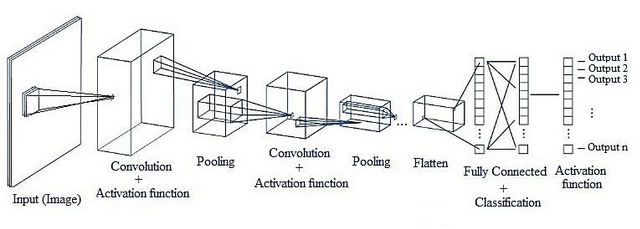

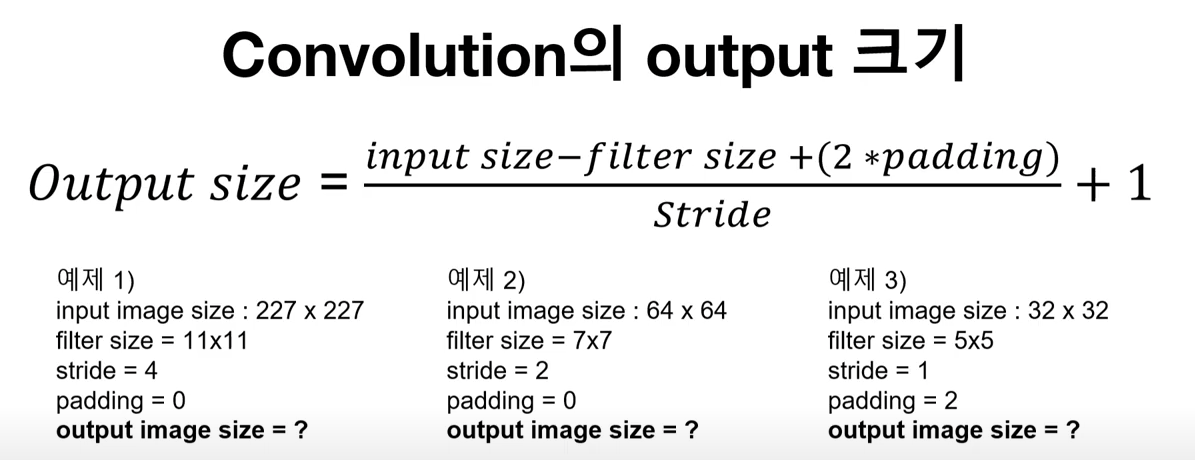

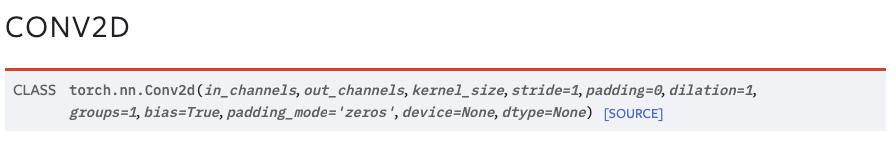

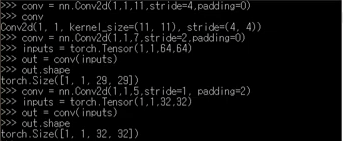

In [149]:
class CNN(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=37, padding=1),
            #nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.Conv2d(6, 12, kernel_size=37, padding=1),
            #nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(0.50),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(12, 24, kernel_size=11, padding=1),
            #nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Conv2d(24, 24, kernel_size=11, padding=1),
            #nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Dropout(0.80),
            nn.MaxPool2d(2, 2),
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(24*31*31, 120),
            nn.ReLU(),
            nn.Linear(120, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes),
        )
        
    def forward(self, x):
        x = self.feature(x)
        #print("After convolution layers:", x.shape)
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화
        #print("After flatten:", x.shape)
        x = self.fc_layer(x)
        return x

Loss function and Optimizer

In [157]:
model = CNN().to(device)

In [158]:
num_epoch = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [159]:
model

CNN(
  (feature): Sequential(
    (0): Conv2d(3, 6, kernel_size=(37, 37), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(6, 12, kernel_size=(37, 37), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(12, 24, kernel_size=(11, 11), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(24, 24, kernel_size=(11, 11), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Dropout(p=0.8, inplace=False)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=23064, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=7, bias=True)
  )
)

In [160]:
model.train()

loss_list = []

for epoch in tqdm(range(num_epoch), desc='epoch'):
    cost = 0.0
    
    for i, [image, label] in enumerate(train_loader):
        x = image.to(device)
        y_ = label.to(device)
        optimizer.zero_grad()
        outputs = model.forward(x)
        loss = criterion(outputs, y_)
        
        # add L2 regularization to avoid overfitting
        # replace pow(2.0) with abs() for L1 regularization
#         l2_lambda = 0.1
#         l2_norm = sum(p.pow(2.0).sum()
#                          for p in model.parameters())
#         loss = loss + l2_lambda + l2_norm
        
        loss.backward()
        optimizer.step()
        
        cost += loss.item()
        
        
    batch_loss = cost / len(train_loader)
    loss_list.append(batch_loss)
    print(f'[{epoch+1}] loss: {batch_loss:.3f}')

epoch:  10%|███████▌                                                                   | 1/10 [04:26<39:57, 266.35s/it]

[1] loss: 1.652


epoch:  20%|███████████████                                                            | 2/10 [08:52<35:31, 266.42s/it]

[2] loss: 1.446


epoch:  30%|██████████████████████▌                                                    | 3/10 [13:18<31:03, 266.26s/it]

[3] loss: 1.332


epoch:  40%|██████████████████████████████                                             | 4/10 [17:45<26:37, 266.20s/it]

[4] loss: 1.250


epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [22:11<22:11, 266.27s/it]

[5] loss: 1.187


epoch:  60%|█████████████████████████████████████████████                              | 6/10 [26:37<17:45, 266.26s/it]

[6] loss: 1.119


epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [31:03<13:18, 266.11s/it]

[7] loss: 1.055


epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [35:29<08:52, 266.22s/it]

[8] loss: 1.007


epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [39:56<04:26, 266.21s/it]

[9] loss: 0.949


epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [44:24<00:00, 266.49s/it]

[10] loss: 0.901


In [165]:
for epoch in tqdm(range(num_epoch, 15), desc='epoch'):
    cost = 0.0
    
    for i, [image, label] in enumerate(train_loader):
        x = image.to(device)
        y_ = label.to(device)
        optimizer.zero_grad()
        outputs = model.forward(x)
        loss = criterion(outputs, y_)
        
        # add L2 regularization to avoid overfitting
        # replace pow(2.0) with abs() for L1 regularization
#         l2_lambda = 0.1
#         l2_norm = sum(p.pow(2.0).sum()
#                          for p in model.parameters())
#         loss = loss + l2_lambda + l2_norm
        
        loss.backward()
        optimizer.step()
        
        cost += loss.item()
        
        
    batch_loss = cost / len(train_loader)
    loss_list.append(batch_loss)
    print(f'[{epoch+1}] loss: {batch_loss:.3f}')

epoch:  20%|███████████████▏                                                            | 1/5 [04:26<17:45, 266.42s/it]

[11] loss: 0.658


epoch:  40%|██████████████████████████████▍                                             | 2/5 [08:52<13:19, 266.46s/it]

[12] loss: 0.479


epoch:  60%|█████████████████████████████████████████████▌                              | 3/5 [13:21<08:55, 267.62s/it]

[13] loss: 0.393


epoch:  80%|████████████████████████████████████████████████████████████▊               | 4/5 [17:47<04:26, 266.93s/it]

[14] loss: 0.326


epoch: 100%|████████████████████████████████████████████████████████████████████████████| 5/5 [22:15<00:00, 267.03s/it]

[15] loss: 0.278


In [ ]:
for epoch in tqdm(range(15, 20), desc='epoch'):
    cost = 0.0
    
    for i, [image, label] in enumerate(train_loader):
        x = image.to(device)
        y_ = label.to(device)
        optimizer.zero_grad()
        outputs = model.forward(x)
        loss = criterion(outputs, y_)
        
        # add L2 regularization to avoid overfitting
        # replace pow(2.0) with abs() for L1 regularization
#         l2_lambda = 0.1
#         l2_norm = sum(p.pow(2.0).sum()
#                          for p in model.parameters())
#         loss = loss + l2_lambda + l2_norm
        
        loss.backward()
        optimizer.step()
        
        cost += loss.item()
        
        
    batch_loss = cost / len(train_loader)
    loss_list.append(batch_loss)
    print(f'[{epoch+1}] loss: {batch_loss:.3f}')

epoch:  20%|███████████████▏                                                            | 1/5 [04:25<17:43, 265.95s/it]

[16] loss: 0.243


epoch:  40%|██████████████████████████████▍                                             | 2/5 [08:51<13:17, 265.87s/it]

[17] loss: 0.221


epoch:  60%|█████████████████████████████████████████████▌                              | 3/5 [13:17<08:51, 265.82s/it]

[18] loss: 0.195


epoch:  80%|████████████████████████████████████████████████████████████▊               | 4/5 [17:49<04:28, 268.13s/it]

[19] loss: 0.174


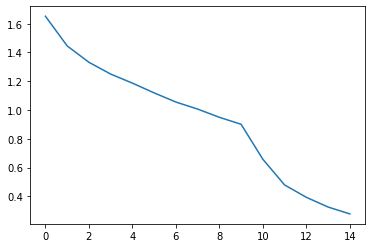

In [166]:
plt.plot(loss_list)
plt.show()

# Save Model

In [169]:
torch.save(model.state_dict(), './model/test_refined_fer_cnn.pt')

In [170]:
load_model = CNN().to(device)
load_model.load_state_dict(torch.load('./model/test_refined_fer_cnn.pt'))

<All keys matched successfully>

## Accuracy of Train Data

In [167]:
# 맞은 개수, 전체 개수
correct = 0
total = 0

model.eval()

# no_grad
with torch.no_grad():
    # 테스트로더에서 이미지와 정답을 불러온다
    for image, label in tqdm(train_loader):
        x = image.to(device)
        y = label.to(device)
        
        # 모델에 데이터를 넣고 결과값 저장
        output = model.forward(x)
        _, output_index = torch.max(output, 1)
        
        # 전체 개수 += label의 개수
        total += label.size(0)
        correct += (output_index == y).sum().float()
    
    # accuracy
    print("Accuracy of Train Data: {}%".format(100 * correct / total))

100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [01:06<00:00, 11.68it/s]

Accuracy of Train Data: 93.5061264038086%


## Accuracy of Test Data

In [168]:
# 맞은 개수, 전체 개수
correct = 0
total = 0

model.eval()

# no_grad
with torch.no_grad():
    # 테스트로더에서 이미지와 정답을 불러온다
    for image, label in tqdm(test_loader, desc="test"):
        x = image.to(device)
        y = label.to(device)
        
        # 모델에 데이터를 넣고 결과값 저장
        output = model.forward(x)
        _, output_index = torch.max(output, 1)
        
        # 전체 개수 += label의 개수
        total += label.size(0)
        correct += (output_index == y).sum().float()
    
    # accuracy
    print("Accuracy of Test Data: {}%".format(100 * correct / total))

test: 100%|██████████████████████████████████████████████████████████████████████████| 195/195 [00:16<00:00, 11.58it/s]

Accuracy of Test Data: 54.317413330078125%
